# <span style="color:yellow">**IMDB Hindi Movies Scraper and EDA** </span>

## Pakages imported :
<ul>
<li> pandas
<li> matplotlib.pyplot
<li> numpy
<li> imdb
<li> re
<li> csv
<li> seaborn
<li> datetime
<li> plotly.express

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imdb import IMDb
import re
import csv
from csv import writer
import seaborn as sns
from datetime import date
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
import os

from matplotlib import style
style.use('ggplot')

To install imdbpy in python run
```
pip install imdbpy
````

### <span style=color:#00ff67>Reading given dataset and storing it as a dataframe to perform further tasks</span>

In [3]:
os.chdir("D:\Programming\Internshala\IMDB Hindi")
df = pd.read_csv("Bollywood Movies Dataset.csv")

## <span style=color:#DB09E1>Cleaning Dataset</span>
Here, I have used **replace** method from pandas to remove special characters from the dataset and replace them with the correct ones.

In [4]:
df['Movie Title'] = df['Movie Title'].str.replace('â€“', ':')
df['Movie Title'] = df['Movie Title'].str.replace('Ã©', 'e')
df['Movie Title'] = df['Movie Title'].str.replace('SachchÃ© KÃ¡ Bol-BÃ¡lÃ¡', 'Sachche Ka Bol-Bala')
df['Movie Title'] = df['Movie Title'].str.replace('â€¦', '...')

The below code is also meant for cleaning. Here, I've used regex to remove values from the datset which, while searched on IMDB do not produce a expected result.<br>

Some movie names are stores as ```'Movie name + (Hindi/Indian + year of release)'```. <br>
But, when you try to search them as it is in the IMDB site, they do not produce results.
Also, some movies produce more than 1 results making it difficult for the algorithm to get the correct movie. In that case, year inside the bracket after movie name is used. Which effectively produces desired results.

In [5]:
#df['Movie Title'] = df['Movie Title'].str.replace(r"\(.*\)","")
df['Movie Title'] = df['Movie Title'].str.replace("film","")
df['Movie Title'] = df['Movie Title'].str.replace("Hindi", "")
df['Movie Title'] = df['Movie Title'].str.replace("Indian", "")
df['Movie Title'] = df['Movie Title'].str.replace(r"\(\)","")
df['Movie Title'] = df['Movie Title'].str.replace(r"(\d)\s", r'\1')
#df['Movie Title'] = re.sub("[^0-9]", "", str(df['Movie Title']))

In [6]:
df.head(10)

,Movie Title
0,3Idiots
1,Taare Zameen Par
2,PK
3,Dangal
4,Rang De Basanti
5,Lagaan
6,My Name Is Khan
7,Swades
8,Gangs of Wasseypur
9,Gangs of Wasseypur : Part 2


## <span style=color:#F1F807>Creating an instance of IMDb class</span>

In [7]:
moviesDB = IMDb()

In [8]:
df['Movie Title'] = df['Movie Title'].astype('str')

In [9]:
len(df['Movie Title'])

4000

Algorithm to traverse the movies from dataset's Movie Title column. The algorithm also searches the movie titles on IMDB website and returns multiple movies which match to the queried movie.<br>

Out of all the movies, the algorithm finds, only first movie(most relevant) is store in an array for further processing.

In [10]:
allMovies = []

for i in range(3500, 4000):
    movies = moviesDB.search_movie(df['Movie Title'][i])
    if (len(movies) == 0):
      continue
    else:
      singleMovie = movies[0]
      allMovies.append(singleMovie)
    #print(i)

### Below code is for testing purpose

'''movies = moviesDB.search_movie(str(df['Movie Title'][0]))
print(movies)
singleMovie = movies[0]
allMovies.append(singleMovie)
#singleMovie
allMovies'''

[<Movie id:1187043[http] title:_3 Idiots (2009)_>, <Movie id:3685624[http] title:_3 idiotas (2017)_>, <Movie id:14280524[http] title:_"I Live Alone" 3 Idiots (2017)_>, <Movie id:12049418[http] title:_"Jeep Bollywood Trails" 3 Idiots (2020)_>, <Movie id:0154421[http] title:_The Idiots (1998)_>, <Movie id:0222441[http] title:_3 Idiots w/GUNS (2000)_>, <Movie id:3607166[http] title:_"Idiotest" (2014)_>, <Movie id:0341476[http] title:_Idiots (2002)_>, <Movie id:3532050[http] title:_"Idiotsitter" (2014)_>, <Movie id:0043614[http] title:_The Idiot (1951)_>, <Movie id:5830890[http] title:_"Vidiots" (2016)_>, <Movie id:1687235[http] title:_Idiots (2010) (V)_>, <Movie id:2622956[http] title:_Idiots (2012)_>, <Movie id:7147976[http] title:_"Idioten" (2017)_>, <Movie id:0366028[http] title:_Idiot (2003)_>, <Movie id:6470848[http] title:_4 Idiots (2012)_>, <Movie id:1637706[http] title:_Our Idiot Brother (2011)_>, <Movie id:2948266[http] title:_Dealin' with Idiots (2013)_>, <Movie id:3054472[http]

[<Movie id:1187043[http] title:_3 Idiots (2009)_>]

## <span style=color:#ff0000>:warning: Warning :warning:</span>
Do not run the following code. As it populates the whole ram and freezes the machine.
I have run it on Amazon SageMaker instance in order to allocate it more memory for running. Even there, it didn;t traverse through all 4000 rows. 
I had run it in the chuncks of 500 and 1000 rows. Prepared different csvs every time.

In [12]:
### FOr loop: traverses over all the movies stored in allMovies List from the previous code block.
for movie in allMovies:

    ### Fetch title of the movie
    title = movie['title'] 
    
    ### Fetch movie ID
    ID = movie.getID()
    
    ### Fetch the year in which movie was released
    ### Try-except: In some cases year is not defined
    try:
        releaseYear = movie['year']
    except:
        releaseYear = 'NA'

    ### object to store name of movie which is euicalent to the IMDB site
    name = moviesDB.get_movie(ID)

    ### Find top-3 genres of a film
    ### In certain cases movies have more than one or even more than five genres.
    ### I've considered only top 3 genres for each movie and stored 'NA' where it isn't available
    try:
        genres = name.data['genres']
        if (len(genres) < 3):
            while (len(genres) != 3):
                genres.append('NA')
        else:
            genres = genres[:3]
    except KeyError:
        while(len(genres) < 3):
            genres.append('NA')

    ### Some times IMDB returns movies from other languages as international movies too have same names as hindi movies
    ### For instance Bobby.
    ### For hindi movies, Hindi is the first language, that's why '0th' index is used        
    try:
        language = name['language'][0]
    except KeyError:
        language = 'NA'
    
    ### Fetching top 3 actors in a movie
    topActors = 3
    actors = []
    try:
        cast = name['cast']
        for actor in cast[:topActors]:
            actors.append(actor['name'])
        while (len(actors) != 3):
            actors.append('NA')
                
    except KeyError:
        while(len(actors) != 3):
            actors.append('NA')

    ### Fetching top 3 crew members 
    topCrews = 3
    crews = []
    try:
        people = name['art department']
        for person in people[:topCrews]:
            crews.append(person['name'])
        if (len(crews) < 3):
            while(len(crews) != 3):
                crews.append('NA')
    except KeyError:
        while (len(crews) != 3):
            crews.append('NA')

    ### Fetch brief plot summary            
    try:
        plot = name['plot outline'] 
    except:
        plot = 'NA'

    ### Gather data of IMDB rating for each movie        
    try:
        rating = name['rating'] 
    except KeyError:
        rating = 'NA'
        
    ### Get number of votes each movie has got
    try:
        votes = name['votes']
    except KeyError:
        votes = 'NA'

    ### Fetch movie URL which redirects to IMDB site
    try:
        URL = moviesDB.get_imdbURL(movie)
    except:
        URL = 'NA'

    ### Build a list of all the values fetched from IMDB
    List = [title, ID, releaseYear, genres[0], genres[1], genres[2], language, actors[0], actors[1], actors[2],
            crews[0], crews[1], crews[2], plot, rating, votes, URL]
    
    ### Store it in a csv file. It keeps on appending the existing csv in every loop it traverses
    with open('temp.csv', 'a') as f:
        writer_obj = writer(f)
        writer_obj.writerow(List)
        f.close()   

## <span style=color:#F80733> Cleaning and Preparing Data (2nd Time)</span>

<p> Now that we have gathered the data, it's time to clean it, again!!    

In [13]:
import os
import glob
os.chdir("D:\Programming\Internshala\IMDB Hindi\Datasets")

In [14]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [6]:
all_filenames

['data_0_1000.csv',
 'data_1000_1500.csv',
 'data_1500_2500.csv',
 'data_2500_3500.csv',
 'data_3500_4000.csv']

## Concatenating five different csv's in order to make a complete csv containg almost 4000 movies with metadata

In [7]:
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
combined_csv.to_csv("df2.csv", index = False, encoding = 'utf-8-sig')

In [15]:
movies = pd.read_csv('df2.csv')

In [16]:
### There are 3970 movies in the dataset and 17 features
movies.shape

(3970, 17)

In [17]:
### Info about every column in the dataset
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3970 entries, 0 to 3969
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            3970 non-null   object 
 1   IMDB ID          3970 non-null   int64  
 2   Date of release  3964 non-null   float64
 3   Genre1           3970 non-null   object 
 4   Genre2           3136 non-null   object 
 5   Genre3           1892 non-null   object 
 6   Language         3931 non-null   object 
 7   Actor1           3944 non-null   object 
 8   Actor2           3935 non-null   object 
 9   Actor3           3928 non-null   object 
 10  Crew1            1886 non-null   object 
 11  Crew2            1145 non-null   object 
 12  Crew3            657 non-null    object 
 13  Plot summary     3444 non-null   object 
 14  IMDB rating      3892 non-null   float64
 15  IMDB votes       3892 non-null   float64
 16  IMDB URL         3970 non-null   object 
dtypes: float64(3),

In [18]:
### statstical information of numerical columns in dataset
movies.describe()

,IMDB ID,Date of release,IMDB rating,IMDB votes
count,3.970000e+03,3964.000000,3892.000000,3892.000000
mean,1.390486e+06,1993.534309,5.873150,3414.618191
std,2.362059e+06,17.831694,1.323862,14426.751860
min,4.218400e+04,1932.000000,1.600000,5.000000
25%,1.656675e+05,1980.000000,4.975000,56.000000
50%,3.488335e+05,1995.000000,6.000000,219.500000
75%,1.436637e+06,2009.000000,6.900000,1514.500000
max,1.525139e+07,2022.000000,9.700000,366440.000000


In [19]:
### Current year is fetched in order to calculate age of content (current year - year of release)
### DOing this will scale the algorithm in future as well
todays_date = date.today()
movies['Age of content'] = todays_date.year - movies['Date of release']

In [20]:
### Print first few rows
movies.head()

,Title,IMDB ID,Date of release,Genre1,Genre2,Genre3,Language,Actor1,Actor2,Actor3,Crew1,Crew2,Crew3,Plot summary,IMDB rating,IMDB votes,IMDB URL,Age of content
0,3 Idiots,1187043,2009.0,Comedy,Drama,NaN,Hindi,Aamir Khan,Madhavan,Sharman Joshi,Saikat Bose,Ajay Chodanker,Jini Dhamande,Farhan Qureshi and Raju Rastogi want to re-uni...,8.4,365203.0,https://www.imdb.com/title/tt1187043/,12.0
1,Like Stars on Earth,986264,2007.0,Drama,Family,NaN,Hindi,Darsheel Safary,Aamir Khan,Tisca Chopra,Aindri Chakraborty,Sunil Gujar,Ramakant Kanojia,Ishaan Awasthi is an eight-year-old child whos...,8.4,179478.0,https://www.imdb.com/title/tt0986264/,14.0
2,PK,2338151,2014.0,Comedy,Drama,Musical,Hindi,Aamir Khan,Rajinder Sharma Nanu,Anushka Sharma,Nimisha Goswami,Manini Mishra,Mahto Mohanlal,P. K. is a comedy of ideas about a stranger in...,8.1,171450.0,https://www.imdb.com/title/tt2338151/,7.0
3,Dangal,5074352,2016.0,Action,Biography,Drama,Hindi,Aamir Khan,Fatima Sana Shaikh,Sanya Malhotra,Sakshi v Kapoor,Rishabh Kushwaha,Sheena Saini,"Biopic of Mahavir Singh Phogat, who taught wre...",8.4,169661.0,https://www.imdb.com/title/tt5074352/,5.0
4,Rang De Basanti,405508,2006.0,Comedy,Crime,Drama,Hindi,Aamir Khan,Siddharth,Sharman Joshi,Manish Baba,Kishen Dagar,Choudhari Nilesh,Sue comes to India to make a film on Indian re...,8.1,116079.0,https://www.imdb.com/title/tt0405508/,15.0


The below cells finds out irregularities in Language column of he datas set. Since, this is assignment is regarding Hindi movies, we will drop all other language movies that our algorithm has athered from IMDB.

In [22]:
print(movies['Language'].unique())
print(len(movies['Language'].unique()))

['Hindi' 'English' 'Persian' nan 'Tamil' 'Bhojpuri' 'Thai' 'Telugu'
 'Norwegian' 'Urdu' 'German' 'Marathi' 'Danish' 'Australian Sign Language'
 'None' 'Japanese' 'Punjabi' 'Filipino' 'Malayalam' 'Turkish' 'Bangla'
 'Maithili' 'Portuguese' 'Korean' 'Gujarati' 'Hungarian' 'Arabic'
 'Spanish' 'Russian' 'Kannada' 'French' 'Haryanvi' 'Italian' 'Nepali'
 'Sinhala' 'Assamese']
36


So, as you can see, there are 36 languages. And we don;t need them. So, we'll drop them

In [23]:
movies.drop(movies[movies['Language'] != 'Hindi'].index, inplace = True)
movies = movies.reset_index(drop = True)

### Finding NA values in IMDB rating and IMDB votes column as these columns are more important to us for calculations and for derieving new column from them.

In [25]:
print(movies['IMDB rating'].isna().sum())
print(movies['IMDB votes'].isna().sum())

20
20


#### Consider rows where rating or votes is not 'NA'

In [34]:
movies = movies[movies['IMDB rating'].notna()]

Below is the calculation of movie popularity column.
Here's the formula I've used for normalizing the rating and votes columns.
They needd to be normalized because some movies have votes in 7 figures where as some have in 2 digits making it difficult to calculte a parameter which can consider raing and votes together.<br>
![formula](https://androidkt.com/wp-content/uploads/2020/10/Selection_060.png)

In [35]:
normalizedRating = []
normalizedVotes = []
m = 0
for i in range(len(movies['IMDB rating'])):
    try:
        normalized = (movies['IMDB rating'][i] - min(movies['IMDB rating'])) / (max(movies['IMDB rating']) - min(movies['IMDB rating']))
        normalizedRating.append(normalized * 10)
    except:
        normalized = 'NA'

for j in range(len(movies['IMDB votes'])):
    try:
        normalized_v = (movies['IMDB votes'][j] - min(movies['IMDB votes'])) / (max(movies['IMDB votes']) - min(movies['IMDB votes']))
        normalizedVotes.append(normalized_v * 10)
    except:
        normalized = 'NA'

Add two columns and find their average to create a new column called "Popularity" which is a blend of rating and votes(normalized)

In [37]:
contentPopularity = np.add(normalizedRating ,normalizedVotes)
contentPopularity = contentPopularity / 2

In [38]:
len(contentPopularity)
movies['Popularity'] = contentPopularity
## Rounding the values to 2 decimals
movies['Popularity'] = round(movies['Popularity'], 2)

Sort movies by popularity column values that we have calculated

In [39]:
MostPopularMovies = movies.sort_values(by = 'Popularity', ascending = False).head()
MostPopularMovies

,Title,IMDB ID,Date of release,Genre1,Genre2,Genre3,Language,Actor1,Actor2,Actor3,Crew1,Crew2,Crew3,Plot summary,IMDB rating,IMDB votes,IMDB URL,Age of content,Popularity
0,3 Idiots,1187043,2009.0,Comedy,Drama,NaN,Hindi,Aamir Khan,Madhavan,Sharman Joshi,Saikat Bose,Ajay Chodanker,Jini Dhamande,Farhan Qureshi and Raju Rastogi want to re-uni...,8.4,365203.0,https://www.imdb.com/title/tt1187043/,12.0,9.79
1,Like Stars on Earth,986264,2007.0,Drama,Family,NaN,Hindi,Darsheel Safary,Aamir Khan,Tisca Chopra,Aindri Chakraborty,Sunil Gujar,Ramakant Kanojia,Ishaan Awasthi is an eight-year-old child whos...,8.4,179478.0,https://www.imdb.com/title/tt0986264/,14.0,7.25
3,Dangal,5074352,2016.0,Action,Biography,Drama,Hindi,Aamir Khan,Fatima Sana Shaikh,Sanya Malhotra,Sakshi v Kapoor,Rishabh Kushwaha,Sheena Saini,"Biopic of Mahavir Singh Phogat, who taught wre...",8.4,169661.0,https://www.imdb.com/title/tt5074352/,5.0,7.11
2,PK,2338151,2014.0,Comedy,Drama,Musical,Hindi,Aamir Khan,Rajinder Sharma Nanu,Anushka Sharma,Nimisha Goswami,Manini Mishra,Mahto Mohanlal,P. K. is a comedy of ideas about a stranger in...,8.1,171450.0,https://www.imdb.com/title/tt2338151/,7.0,6.92
4,Rang De Basanti,405508,2006.0,Comedy,Crime,Drama,Hindi,Aamir Khan,Siddharth,Sharman Joshi,Manish Baba,Kishen Dagar,Choudhari Nilesh,Sue comes to India to make a film on Indian re...,8.1,116079.0,https://www.imdb.com/title/tt0405508/,15.0,6.17


In [40]:
## In above output rlease year is represented as float. We need to convert it to integer
movies['Date of release'] = movies['Date of release'].astype(int)

### Worst Movies (baseed on popularity index)

In [41]:
LeastPopularMovies = movies.sort_values(by = 'Popularity', ascending = True).head()
LeastPopularMovies

,Title,IMDB ID,Date of release,Genre1,Genre2,Genre3,Language,Actor1,Actor2,Actor3,Crew1,Crew2,Crew3,Plot summary,IMDB rating,IMDB votes,IMDB URL,Age of content,Popularity
1759,Jimmy,1228707,2008,Action,Crime,Drama,Hindi,Mimoh Chakraborty,Vikas Anand,Rahul Dev,NaN,NaN,NaN,"In the dead of the night, a young woman's dead...",1.6,263.0,https://www.imdb.com/title/tt1228707/,13.0,0.00
1307,Prem Aggan,210920,1998,Drama,Romance,NaN,Hindi,Fardeen Khan,Meghna Kothari,Sameer Malhotra,NaN,NaN,NaN,"Jai Kumar is a wealthy industrialist, and live...",1.7,556.0,https://www.imdb.com/title/tt0210920/,23.0,0.08
1221,Chatur Singh Two Star,1363363,2011,Action,Adventure,Comedy,Hindi,Sanjay Dutt,Ameesha Patel,Anupam Kher,NaN,NaN,NaN,"After an incident at Dadar Railway Station, Mu...",1.7,644.0,https://www.imdb.com/title/tt1363363/,10.0,0.08
292,Humshakals,3036740,2014,Comedy,Drama,Romance,Hindi,Saif Ali Khan,Riteish Deshmukh,Ram Kapoor,David Addison Myers,David Bryan,George Morris,Ashok a millionaire and his friend Kumar are a...,1.7,7995.0,https://www.imdb.com/title/tt3036740/,7.0,0.18
284,Himmatwala,2344678,2013,Action,Comedy,Drama,Hindi,Ajay Devgn,Tamannaah Bhatia,Paresh Rawal,Kshamata Sachin Gurav,Sagar Mali,Rupin Suchak,An honest temple priest takes on more than he ...,1.7,8367.0,https://www.imdb.com/title/tt2344678/,8.0,0.18


## Create new dataframe for EDA
EDA based on Actors involved in the film


In [42]:
df2 = movies[['Title', 'Actor1', 'Actor2', 'Actor3', 'IMDB rating', 'Popularity']]
df2.head()

,Title,Actor1,Actor2,Actor3,IMDB rating,Popularity
0,3 Idiots,Aamir Khan,Madhavan,Sharman Joshi,8.4,9.79
1,Like Stars on Earth,Darsheel Safary,Aamir Khan,Tisca Chopra,8.4,7.25
2,PK,Aamir Khan,Rajinder Sharma Nanu,Anushka Sharma,8.1,6.92
3,Dangal,Aamir Khan,Fatima Sana Shaikh,Sanya Malhotra,8.4,7.11
4,Rang De Basanti,Aamir Khan,Siddharth,Sharman Joshi,8.1,6.17


## Top actors in ***leading role*** and number of movies they have acted in

Jeetendra             106
Dharmendra            103
Rajesh Khanna          95
Amitabh Bachchan       95
Mithun Chakraborty     88
Name: Actor1, dtype: int64


<AxesSubplot:>

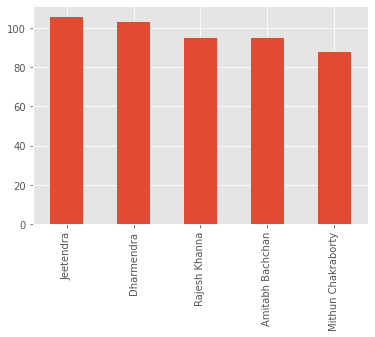

In [43]:
freq = df2.Actor1.value_counts()
print(freq.head())
freq.head().plot.bar()

## ***Supporting actor/actress*** appeared in most movies (based on Actor2 column)

Rekha                 54
Hema Malini           54
Dharmendra            41
Juhi Chawla           36
Mithun Chakraborty    35
Name: Actor2, dtype: int64


<AxesSubplot:>

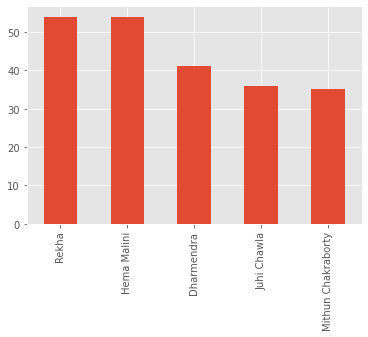

In [44]:
freq2 = df2.Actor2.value_counts()
print(freq2.head())
freq2.head().plot.bar()

## ***Supporting actor/villian*** who appeared in most number of movies as Actor 3 in movie

Pran            49
Anupam Kher     41
Prem Chopra     33
Amrish Puri     31
Paresh Rawal    28
Name: Actor3, dtype: int64


<AxesSubplot:>

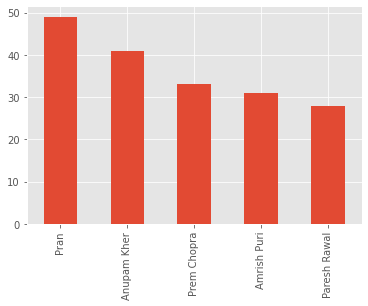

In [45]:
freq3 = df2.Actor3.value_counts()
print(freq3.head())
freq3.head().plot.bar()

## **Trios** which were most successful based on IMDB rating of the movie they appeared in

In [46]:
topRatedActor1 = df2.groupby(['Title','Actor1', 'Actor2', 'Actor3'])['IMDB rating'].mean()
topRatedActor1.sort_values(ascending = False).head(10)

Title                      Actor1            Actor2              Actor3             
Koshish                    Sanjeev Kumar     Jaya Bachchan       Asrani                 8.6
Sachin - A Billion Dreams  Sachin Tendulkar  Mikhail Gandhi      Anjali Tendulkar       8.6
Dharam Veer                Mugdha Chaphekar  Vikrant Massey      Rajat Tokas            8.6
Shrimaan Shrimati          Jatin Kanakia     Reema Lagoo         Archana Puran Singh    8.6
Eclipse                    Zoya Hussain      Wamiqa Gabbi        Anshuman Pushkar       8.6
Pyaasa                     Guru Dutt         Waheeda Rehman      Mala Sinha             8.5
Hanky Panky                Amol Palekar      Bindiya Goswami     Deven Verma            8.5
Panchlait                  Amitosh Nagpal    Yashpal Sharma      Brijendra Kala         8.5
Hip Hip Hurray             Bhoomika Chawla   Pamela Mukherjee    Rushad Rana            8.5
Dangal                     Aamir Khan        Fatima Sana Shaikh  Sanya Malhotra        

## Most appeared(:stuck_out_tongue:) crew in movies which were rated high by audience

In [47]:
df3 = movies[['Crew1', 'Crew2', 'Crew3', 'IMDB rating']]
df3.head()

,Crew1,Crew2,Crew3,IMDB rating
0,Saikat Bose,Ajay Chodanker,Jini Dhamande,8.4
1,Aindri Chakraborty,Sunil Gujar,Ramakant Kanojia,8.4
2,Nimisha Goswami,Manini Mishra,Mahto Mohanlal,8.1
3,Sakshi v Kapoor,Rishabh Kushwaha,Sheena Saini,8.4
4,Manish Baba,Kishen Dagar,Choudhari Nilesh,8.1


In [48]:
### Top crew member among top 3 crew members and number of films in which they were involved
freqCrew1 = df3.Crew1.value_counts()
freqCrew1.head()

Shankar Chougle    25
Chanchal Bisht     24
Ibrahim Mamoo      23
Prakash Shetty     23
Anand Kalekar      22
Name: Crew1, dtype: int64

In [49]:
### Second top crew member among top 3 crew members and number of films in which they were involved
freqCrew2 = df3.Crew2.value_counts()
freqCrew2.head()

Dilip Singh          25
Suresh Sawant        15
Mohammed Kasim       12
Ram Gopal Sharma     11
Menon Mohd. Yusuf     9
Name: Crew2, dtype: int64

In [50]:
### Third top crew member among top 3 crew members and number of films in which they were involved
freqCrew3 = df3.Crew3.value_counts()
freqCrew3.head()

Dilip Singh        11
Gurudayal Singh    11
Gautam Jadhav       7
Abhijit Khatu       6
Nitin Kulkarni      5
Name: Crew3, dtype: int64

## Average rating of a movie in which certain crew member was a part of a team

In [51]:
topRatedCrew = df3.groupby(['Crew1'])['IMDB rating'].mean()
topRatedCrew.head()

Crew1
A. Abbas           6.333333
A. Karnachari      5.933333
A. Nagar Athram    6.800000
A.G. Kadam         5.775000
A.K. Abdul         2.400000
Name: IMDB rating, dtype: float64

## Distribution of rating across films

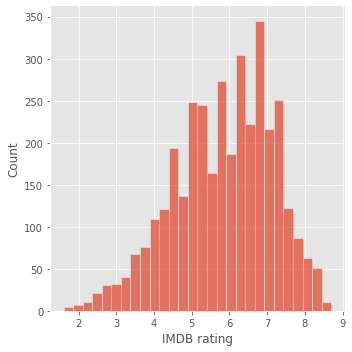

In [52]:
sns.displot(movies['IMDB rating'])

## EDA of Genres

In [53]:
df_by_genre = movies[['Genre1', 'Genre2', 'Genre3', 'IMDB votes']]

In [54]:
### New column to count the number of times the genre is listed
df_by_genre['cnt'] = 1
df_by_genre.head()

,Genre1,Genre2,Genre3,IMDB votes,cnt
0,Comedy,Drama,NaN,365203.0,1
1,Drama,Family,NaN,179478.0,1
2,Comedy,Drama,Musical,171450.0,1
3,Action,Biography,Drama,169661.0,1
4,Comedy,Crime,Drama,116079.0,1


In [55]:
### Groupby is used to goup movies my genre and then find their sum in order find the count of genre1
df_by_g1 = df_by_genre.groupby(['Genre1']).sum()
df_by_g1.sort_values(by = 'cnt', ascending = False)

,IMDB votes,cnt
Genre1,,
Action,3879874.0,1252
Drama,2511293.0,1099
Comedy,3414521.0,703
Crime,764983.0,158
Romance,18314.0,99
Musical,65159.0,69
Horror,37521.0,46
Adventure,86758.0,43
Biography,314511.0,40


In [56]:
### Genre2 statistics
df_by_g2 = df_by_genre.groupby(['Genre2']).sum()
df_by_g2.sort_values(by = 'cnt', ascending = False)

,IMDB votes,cnt
Genre2,,
Drama,4568046.0,989
Romance,1033210.0,462
Crime,1483496.0,391
Comedy,971602.0,240
Family,381903.0,214
Thriller,231591.0,155
Musical,492879.0,146
Adventure,474794.0,108
Mystery,98844.0,86


In [57]:
### Genre2 statistics
df_by_g3 = df_by_genre.groupby(['Genre3']).sum()
df_by_g3.sort_values(by = 'cnt', ascending = False)

,IMDB votes,cnt
Genre3,,
Romance,1794761.0,485
Drama,1849635.0,477
Thriller,871719.0,259
Musical,715527.0,118
Family,162420.0,92
Crime,398502.0,84
Mystery,556287.0,79
Comedy,266682.0,37
Fantasy,140966.0,34


In [58]:
### All three dfs are added in order to calculate total number of times a genre was listed for movies
temp = df_by_g1.add(df_by_g2, fill_value = 0)
df_add = temp.add(df_by_g3, fill_value = 0)
df_add = df_add.sort_values(by = 'cnt', ascending = False)

In [59]:
### Plot of top 10 Genres of Hindi Films
### It is an interactive map
df_add_1 = df_add.head(10)
fig = px.bar(df_add_1, x = df_add_1.index, y='cnt', color = 'cnt')
fig.show()

# Actors who appeared in most number of films

In [60]:
df_by_actors = movies[['Actor1', 'Actor2', 'Actor3', 'IMDB votes']]

In [61]:
df_by_actors['cnt'] = 1
df_by_actors.head()

,Actor1,Actor2,Actor3,IMDB votes,cnt
0,Aamir Khan,Madhavan,Sharman Joshi,365203.0,1
1,Darsheel Safary,Aamir Khan,Tisca Chopra,179478.0,1
2,Aamir Khan,Rajinder Sharma Nanu,Anushka Sharma,171450.0,1
3,Aamir Khan,Fatima Sana Shaikh,Sanya Malhotra,169661.0,1
4,Aamir Khan,Siddharth,Sharman Joshi,116079.0,1


In [62]:
df_by_a1 = df_by_actors.groupby(['Actor1']).sum()
df_by_a1.sort_values(by = 'cnt', ascending = False)

,IMDB votes,cnt
Actor1,,
Jeetendra,9926.0,106
Dharmendra,57941.0,103
Rajesh Khanna,58386.0,95
Amitabh Bachchan,439986.0,95
Mithun Chakraborty,44001.0,88
...,...,...
Laila,677.0,1
Lakshmi,276.0,1
Lalita Pawar,38.0,1


In [63]:
df_by_a2 = df_by_actors.groupby(['Actor2']).sum()
df_by_a2.sort_values(by = 'cnt', ascending = False)

,IMDB votes,cnt
Actor2,,
Rekha,35916.0,54
Hema Malini,29146.0,54
Dharmendra,58860.0,41
Juhi Chawla,79899.0,36
Mithun Chakraborty,40279.0,35
...,...,...
Manjeet Kular,326.0,1
Manju Asrani,12.0,1
Manjusha Godse,30.0,1


In [64]:
df_by_a3 = df_by_actors.groupby(['Actor3']).sum()
df_by_a3.sort_values(by = 'cnt', ascending = False)

,IMDB votes,cnt
Actor3,,
Pran,26450.0,49
Anupam Kher,219585.0,41
Prem Chopra,5394.0,33
Amrish Puri,168295.0,31
Paresh Rawal,156094.0,28
...,...,...
Kriti Kharbanda,525.0,1
Kriti Malhotra,12841.0,1
Kulraj Randhawa,197.0,1


In [65]:
temp2 = df_by_a1.add(df_by_a2, fill_value = 0)
df_add2 = temp2.add(df_by_a3, fill_value = 0)
df_add2 = df_add2.sort_values(by = 'cnt', ascending = False)
df_add2.head(10)

,IMDB votes,cnt
Dharmendra,117598.0,153.0
Mithun Chakraborty,143837.0,146.0
Jeetendra,13309.0,133.0
Amitabh Bachchan,685872.0,132.0
Sanjay Dutt,313420.0,106.0
Rajesh Khanna,59722.0,106.0
Akshay Kumar,834424.0,99.0
Rishi Kapoor,207440.0,93.0
Rekha,63209.0,92.0
Ashok Kumar,16043.0,90.0


In [66]:
df_add_actors = df_add2.head(10)
fig = px.bar(df_add_actors, x = df_add_actors.index, y='cnt', color = 'cnt')
fig.show()

It is evident from above plot that Dharmendra has appeared in the most number of movies (based on out dataset)